In [4]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append("..")

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [6]:
from tqdm.auto import tqdm

## Preprocess

In [7]:
from pathlib import Path

ROOT_DATA_DIR = Path("../data/")

all data has format (timestamp, value, target) where target is 0 or 1 with other optional columns

### NAB

In [5]:
DATA_DIR = ROOT_DATA_DIR / "NAB"

In [6]:
mt = pd.read_csv(DATA_DIR / "machine_temperature_system_failure.csv", parse_dates=[0])
sp = pd.read_csv(DATA_DIR / "speed_7578.csv", parse_dates=[0])
at = pd.read_csv(DATA_DIR / "ambient_temperature_system_failure.csv", parse_dates=[0])
nt = pd.read_csv(DATA_DIR / "nyc_taxi.csv", parse_dates=[0])

preprocess the dataframes...

In [7]:
import json

with open(DATA_DIR / "combined_windows.json", "r") as f:
    labels = json.load(f)
obj2name = [
    (mt, "realKnownCause/machine_temperature_system_failure.csv"),
    (sp, "realTraffic/speed_7578.csv"),
    (at, "realKnownCause/ambient_temperature_system_failure.csv"),
    (nt, "realKnownCause/nyc_taxi.csv"),
]
for ds_obj, dataset in obj2name:
    ds_obj["target"] = 0

    for w in labels[dataset]:
        anomalies_mask = (ds_obj["timestamp"] >= w[0]) & (ds_obj["timestamp"] <= w[1])
        ds_obj.loc[anomalies_mask, "target"] = 1

In [8]:
# save processed dataframes to DATA_DIR/processed
for ds_obj, dataset in obj2name:
    ds_obj.to_parquet(
        DATA_DIR / f'processed_{dataset.split("/")[-1].split(".")[0]}.parquet',
        index=False,
    )

optionally plot the dfs

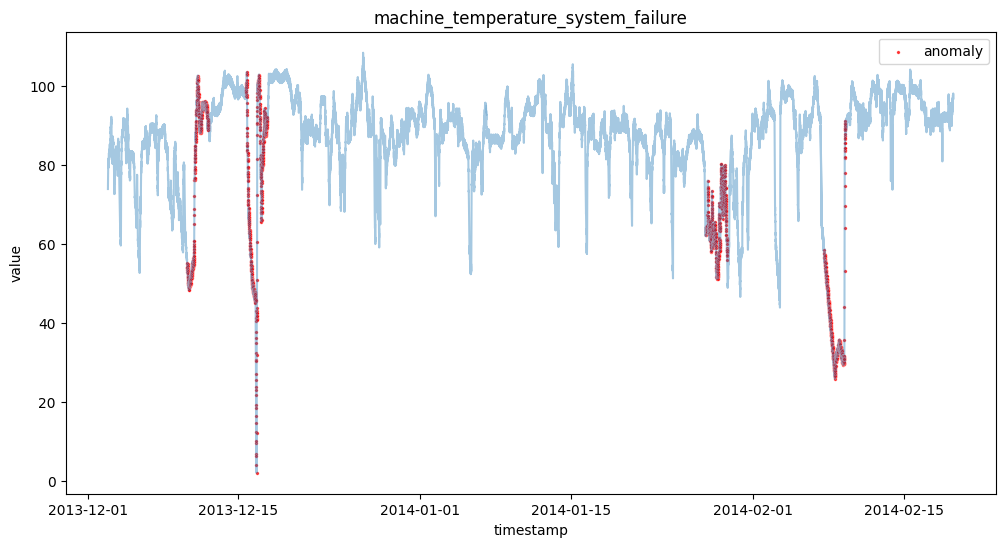

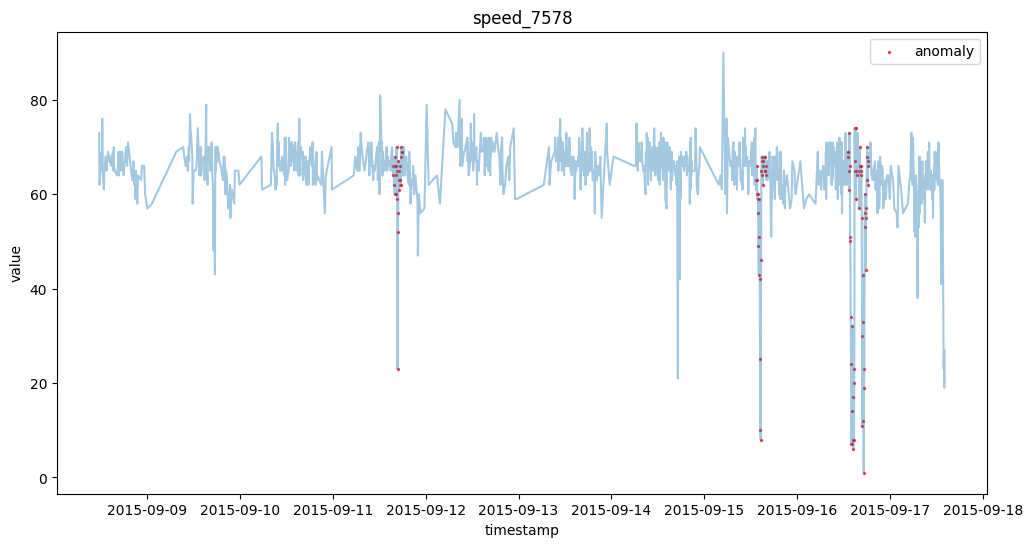

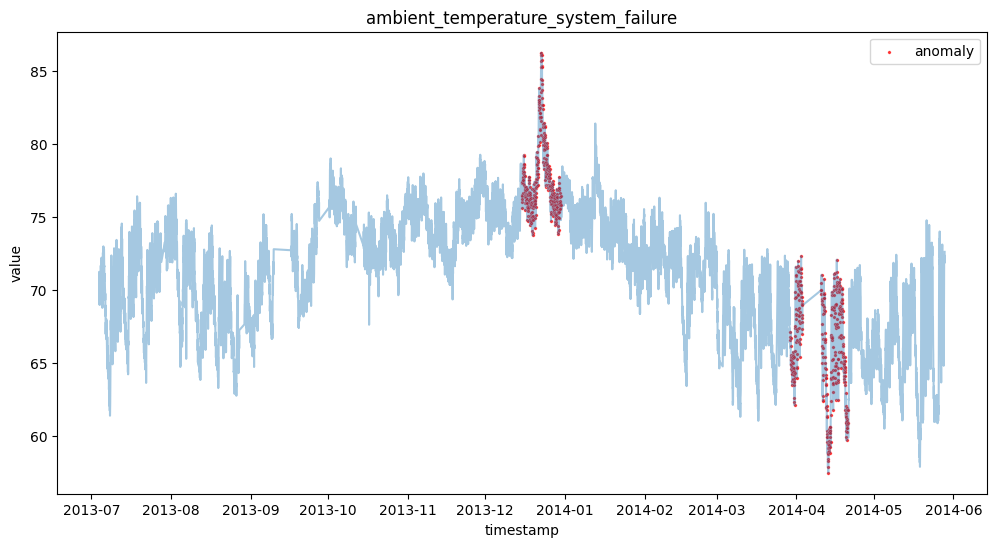

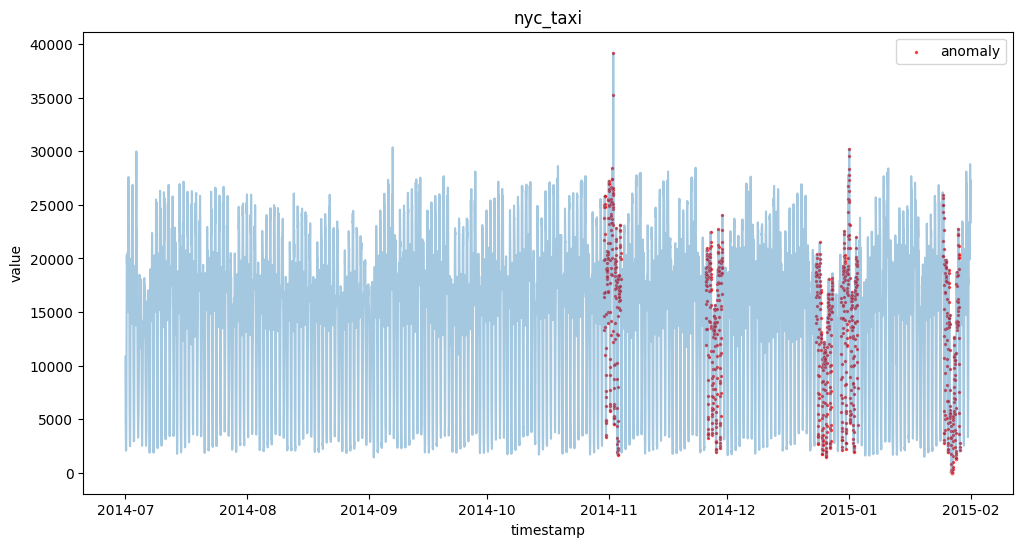

In [9]:
for ds_obj, dataset in obj2name:
    fig,axs=plt.subplots(figsize=(12, 6))
    sns.lineplot(x='timestamp', y='value', data=ds_obj, alpha=0.4)
    sns.scatterplot(x='timestamp', y='value', data=ds_obj[ds_obj['target']==1],
                    color='red', label='anomaly', alpha=0.8, s=6)
    plt.title(dataset.split('/')[-1].split('.')[0])
    plt.show()

In [18]:
df = obj2name[3][0]

In [21]:
df.target.value_counts(normalize=True)

target
0    0.899709
1    0.100291
Name: proportion, dtype: float64

In [22]:
len(df)

10320

## FI2010

In [8]:
DATA_DIR = ROOT_DATA_DIR / "FI2010"

In [9]:
# run the FI2010_Data_Analysis first
df = pd.read_parquet(DATA_DIR / "processed.parquet")

df = df.loc[:, ["50", "stock", "day", "train"]]
df["value"] = df.iloc[:, 0]
df.drop(columns=["50"], inplace=True)

In [10]:
np.random.seed(1)
df.sample(10, random_state=1)

,stock,day,train,value
1855544,5,4,0,0.34095
719042,5,5,1,0.36120
476658,4,4,1,0.12685
1694779,1,0,0,0.26785
753510,5,5,1,0.34200
1766755,2,2,0,0.12635
105246,5,1,1,0.34775
1798936,2,3,0,0.12365
650882,4,5,1,0.12705
290379,4,3,1,0.12600


In [11]:
df["timestamp"] = df.groupby(["stock", "day"])["value"].cumcount() + 1

optionally check if the timestamp makes sense

In [12]:
# df.groupby(['stock', 'day'])['timestamp'].max()

In [105]:
def get_outliers(g, prop_outliers, outliers_range):
    x = g["value"].to_numpy().copy()
    g["original_value"] = g["value"]

    outliers_pos = np.random.choice(len(x), size=int(len(x) * prop_outliers))

    rets_outliers = np.random.uniform(size=outliers_pos.shape[0], low=-outliers_range, high=outliers_range)
    # rets_outliers = np.random.binomial(n=1, p=0.5, size=outliers_pos.shape[0]).astype(np.float32) * 2 - 1  # for testing
    rets_outliers *= outliers_range

    x[outliers_pos] += rets_outliers * x[outliers_pos]

    g["target"] = 0
    g.iloc[outliers_pos, -1] = 1

    g["value"] = x
    return g

In [106]:
def plot_outliers(g, desc="", save=True):
    x = g["original_value"].to_numpy()
    r = g["value"].to_numpy()
    outliers_pos = np.where(g["target"].to_numpy())[0]
    
    # visually check
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))
    fig.suptitle(f"{desc}")
    plt.subplot(2, 2, 1)
    g_outlier = g.query('target == 1')
    plt.plot(g['original_value'], label="Original time series", zorder=0, alpha=0.5)
    plt.plot(g['value'], label="Time series with outliers", zorder=0, alpha=0.5)
    plt.scatter(g_outlier.index, y=g_outlier['value'], label='outlier', color="red", s=2, zorder=1)
    plt.legend()
    plt.title("Mid price")
    
    plt.subplot(2, 2, 2)
    plt.hist(x, bins=30, alpha=0.5)
    plt.hist(r, bins=30, alpha=0.5)
    plt.yscale("log")
    
    plt.subplot(2, 2, 3)
    g_diff = g.copy()
    g_diff['orig_diff'] = g_diff['original_value'].diff()
    g_diff['diff'] = g_diff['value'].diff()
    g_outlier_diff = g_diff.query('target == 1')
    
    plt.plot(g_diff['orig_diff'], label="Original time series", zorder=0, alpha=0.5)
    plt.plot(g_diff['diff'], label="Time series with outliers", zorder=0, alpha=0.5)
    plt.scatter(g_outlier_diff.index, y=g_outlier_diff['diff'], label='outlier', color="red", s=2, zorder=1)
    
    plt.subplot(2, 2, 4)
    plt.hist(np.diff(x), bins=30, alpha=0.5)
    plt.hist(np.diff(r), bins=30, alpha=0.5)
    plt.yscale("log")

    plt.tight_layout()
    plt.plot()
    if save:
        plt.savefig(f"images/tf_mid_{desc}.png")
        plt.close()
    else:
        plt.show()

3903


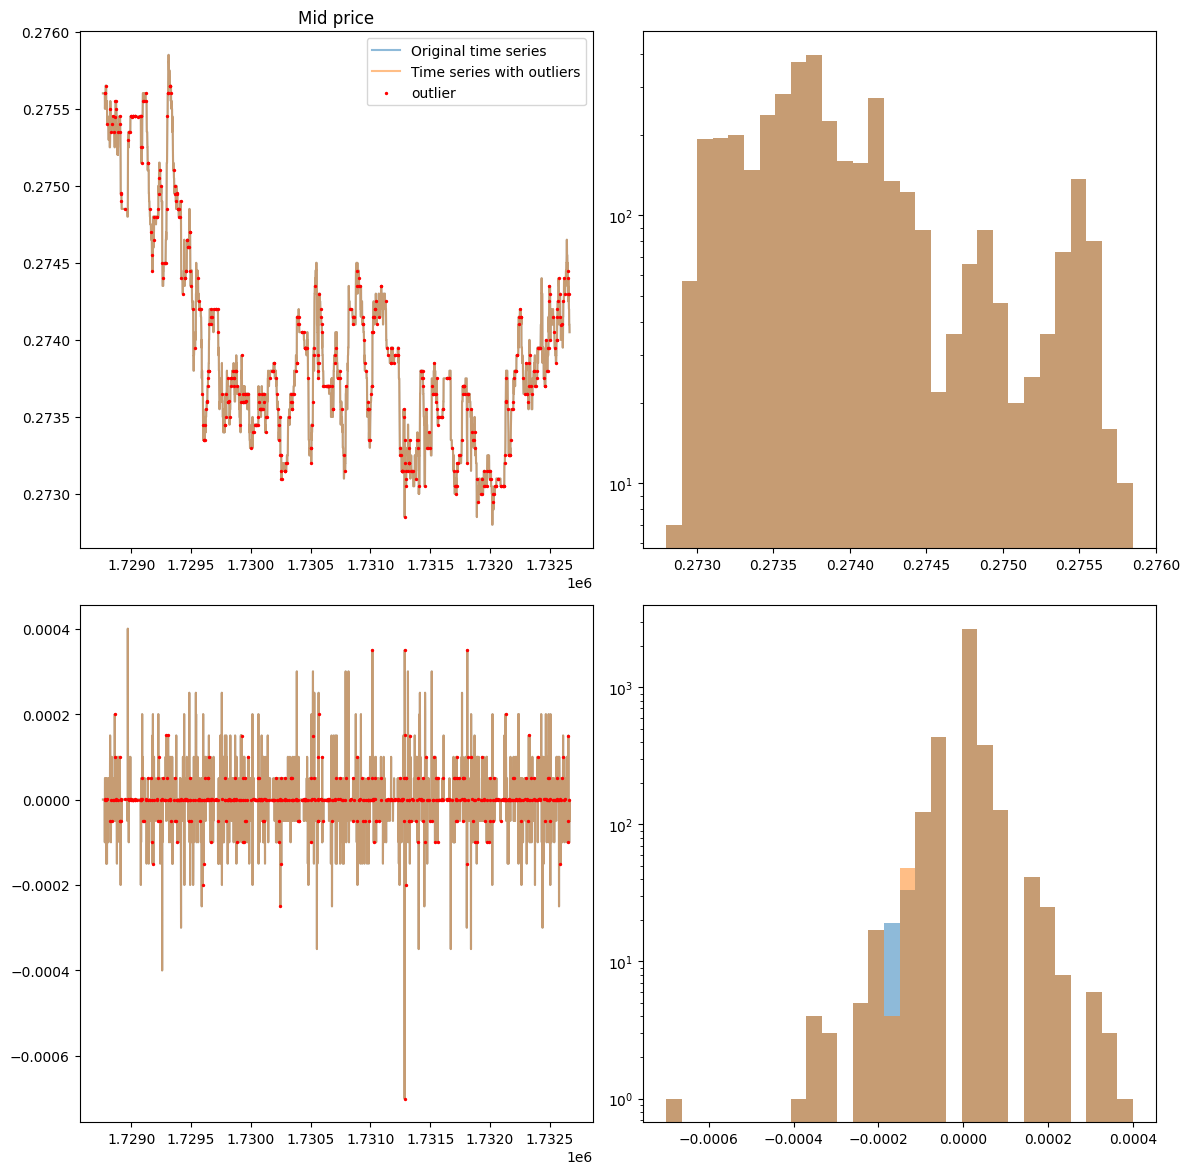

In [113]:
np.random.seed(1)

prop_outliers = 0.15
outliers_range = 0.001
g = df.query("stock==1 & day==1 & train==0").copy()
print(len(g))
g = get_outliers(g, prop_outliers=prop_outliers, outliers_range=outliers_range)
plot_outliers(g, save=False)

In [114]:
# g.loc[1728770:1728790]

In [115]:
# g[g['target'] == 1]

In [116]:
np.random.seed(1)

all_w_out = []
for desc, g in df.groupby(["stock", "day", "train"]):
    g = g.copy()
    g = get_outliers(g, prop_outliers=prop_outliers, outliers_range=outliers_range)
    all_w_out.append(g)
all_w_out = pd.concat(all_w_out)

# so that train=1 is before train=0
all_w_out.sort_values(["stock", "day", "timestamp"], inplace=True)

all_w_out.reset_index(drop=True, inplace=True)

In [117]:
all_w_out.to_parquet(DATA_DIR / "all_with_anomalies.parquet")

In [118]:
all_w_out.head()

,stock,day,train,value,timestamp,original_value,target
0,1,0,1,0.26105,1,0.26105,0
1,1,0,1,0.26105,2,0.26105,0
2,1,0,1,0.26100,3,0.26100,1
3,1,0,1,0.26100,4,0.26100,0
4,1,0,1,0.26100,5,0.26100,0


optionally plot the outliers

In [19]:
# for desc, g in tqdm(all_w_out.groupby(["stock", "day", "train"])):
#     g = g.copy()
#     plot_outliers(g, desc)

plot the first group

  0%|          | 0/90 [00:00<?, ?it/s]

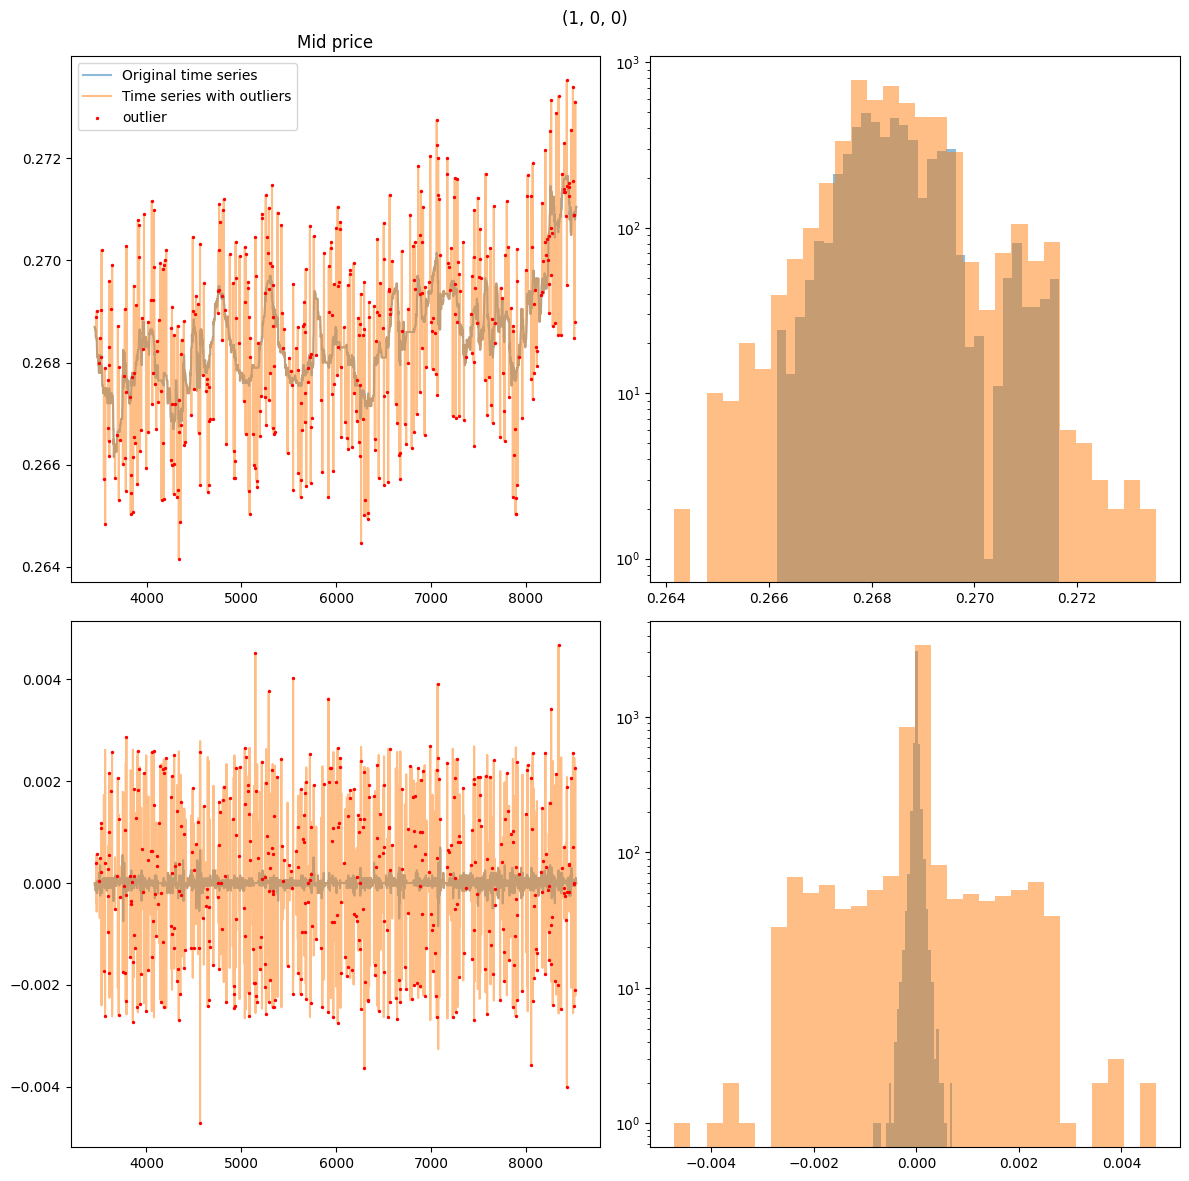

In [20]:
# for desc, g in tqdm(all_w_out.groupby(["stock", "day", "train"])):
#     g = g.copy()
#     plot_outliers(g, desc, save=False)
#     break